# Intro

We train mixture density network (https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) and a equivalent network using MC dropout (https://arxiv.org/pdf/1506.02142.pdf) on 1D toy data. As target distribution we choose the individual modes to be gaussians. We subsequently compare the uncertainty estimates for in and out of distribution samples

We will see that both uncertainty estimates complement each other. MDNs deliver a better estimate of the actual noise of the data. Whereas MC dropout yields a better estimate for the model uncertainty as can be seen in the uncertainty estimates on the out of distribution samples.

# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# Create toy dataset

One dimensional sine function with noise from two different gaussians with zero mean

In [2]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3

# Training
X = np.random.uniform(0, max_tr, N)
Y = np.sin(X) + np.random.normal(loc=0, scale=sig1, size=N) + np.random.normal(loc=0, scale=sig2, size=N)

# Validation
X_val = np.random.uniform(min_val, max_val, N_val)
Y_val = np.sin(X_val) + np.random.normal(loc=0, scale=sig1, size=N_val) + np.random.normal(loc=0, scale=sig2, size=N_val)

# Out of distribution samples
X_test1 = np.random.uniform(min_val-10, min_val, int(N_val/2))
X_test2 = np.random.uniform(max_val, max_val+10, int(N_val/2))
X_test = np.concatenate([X_test1, X_test2], axis=0)
Y_test = np.sin(X_test) + np.random.normal(loc=0, scale=sig1, size=N_val) + \
            np.random.normal(loc=0, scale=sig2, size=N_val)

Visualize data

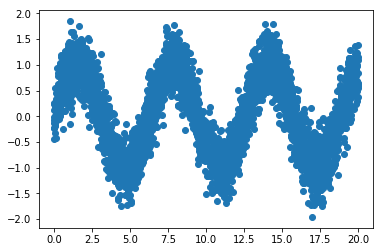

In [3]:
plt.figure()
plt.scatter(X, Y)
plt.show()

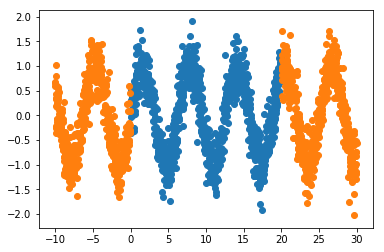

In [4]:
plt.figure()
plt.scatter(X_val, Y_val)
plt.scatter(X_test, Y_test)
plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [5]:
# Hyperparameters
lr = 0.001
lr_mdn = 0.001
batch_size = 128
epochs = 1000
patience = 20
modes = 1
dropout_rate = 0.15
mc_samples = 50

In [6]:
def mdn_loss(y_true, y_pred):
    """
    Computes mdn loss
    
    args:
        y_true: labels plus dummy labels for std and weight 
        y_pred: prediction
        
    returns:
        loss
    """
    
    targets = y_true[:, :1]
    means = y_pred[:, :modes]
    std = tf.square(tf.exp(y_pred[:, modes:2*modes]))
    weights = y_pred[:, 2*modes:3*modes]
    
    modes_prob = []
    for i in range(modes):
        diff = tf.subtract(targets, means[:, i:(i+1)])
        m_loss_log = -1*tf.divide(tf.square(diff), 2*std[:, i:(i+1)]) - tf.sqrt(2*np.pi*std[:, i:(i+1)]) + tf.log(weights[:, i:(i+1)])
        modes_prob.append(m_loss_log)
        
    prob = tf.concat(modes_prob, axis=1)
    
    loss = tf.reduce_logsumexp(prob, axis=1)
    loss = tf.reduce_mean(loss, axis=0)
    
    return (-1)*loss

In [7]:
def get_model(mdn=False, dropout=False):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(250, activation='relu')(dense)
    if dropout:
        dense = Dropout(dropout_rate)(dense)
#         dense = Lambda(lambda x: K.dropout(x, level=dropout_rate))(dense)
    dense = Dense(100, activation='relu')(dense)
    if dropout:
        dense = Dropout(dropout_rate)(dense)
#         dense = Lambda(lambda x: K.dropout(x, level=dropout_rate))(dense)
    
    if not mdn:
        out = Dense(1)(dense)
    else:
        out_mean = Dense(modes)(dense)
        
        out_std = Dense(modes, name='std')(dense)
        
        out_weights = Dense(modes, activation='softmax')(dense)
        
        out = Concatenate(axis=1)([out_mean, out_std, out_weights])
    
    model = Model(inputs=[inp], outputs=[out])
    
    if not mdn:
        model.compile(Adam(lr=lr), loss='mse')
    else:
        model.compile(Adam(lr=lr_mdn), loss=mdn_loss)
    
    return model

Fit mixture density network to data

In [8]:
model_mdn = get_model(mdn=True, dropout=True)

In [9]:
model_mdn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 250)          25250       dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 250)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

In [10]:
Y_mdn = np.concatenate([np.reshape(Y, (Y.shape[0], 1)), np.zeros((Y.shape[0], modes*3-1))], axis=1)
Y_mdn_val = np.concatenate([np.reshape(Y_val, (Y_val.shape[0], 1)), np.zeros((Y_val.shape[0], modes*3-1))], axis=1)

model_mdn.fit(
    x = X,
    y = Y_mdn,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_mdn_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 336us/step - loss: 2.7450 - val_loss: 2.3857
Epoch 2/1000
4000/4000 [==============================] - 0s 39us/step - loss: 2.4235 - val_loss: 2.3078
Epoch 3/1000
4000/4000 [==============================] - 0s 40us/step - loss: 2.3132 - val_loss: 2.2348
Epoch 4/1000
4000/4000 [==============================] - 0s 40us/step - loss: 2.2535 - val_loss: 2.2123
Epoch 5/1000
4000/4000 [==============================] - 0s 41us/step - loss: 2.2274 - val_loss: 2.1693
Epoch 6/1000
4000/4000 [==============================] - 0s 41us/step - loss: 2.1939 - val_loss: 2.1640
Epoch 7/1000
4000/4000 [==============================] - 0s 45us/step - loss: 2.1938 - val_loss: 2.1567
Epoch 8/1000
4000/4000 [==============================] - 0s 38us/step - loss: 2.1830 - val_loss: 2.1504
Epoch 9/1000
4000/4000 [==============================] - 0s 41us/step - loss: 2.1655 - val_loss: 2.1499
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.8022 - val_loss: 1.7664
Epoch 79/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.8185 - val_loss: 1.7495
Epoch 80/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.7926 - val_loss: 1.7769
Epoch 81/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.8070 - val_loss: 1.7406
Epoch 82/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.7890 - val_loss: 1.7365
Epoch 83/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.7846 - val_loss: 1.7224
Epoch 84/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.7671 - val_loss: 1.7177
Epoch 85/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.7655 - val_loss: 1.7187
Epoch 86/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.7850 - val_loss: 1.7278
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.6158 - val_loss: 1.5115
Epoch 156/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.6160 - val_loss: 1.4963
Epoch 157/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.6056 - val_loss: 1.5432
Epoch 158/1000
4000/4000 [==============================] - 0s 38us/step - loss: 1.6071 - val_loss: 1.5017
Epoch 159/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.6009 - val_loss: 1.4893
Epoch 160/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.5937 - val_loss: 1.4999
Epoch 161/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.6208 - val_loss: 1.5380
Epoch 162/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.6075 - val_loss: 1.4978
Epoch 163/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.5840 - val_loss: 1.5099
Epoch 164/1000
4000/4000 [===========

4000/4000 [==============================] - 0s 41us/step - loss: 1.4786 - val_loss: 1.3505
Epoch 232/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.4728 - val_loss: 1.3741
Epoch 233/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.4641 - val_loss: 1.3942
Epoch 234/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.4853 - val_loss: 1.3557
Epoch 235/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.4678 - val_loss: 1.3685
Epoch 236/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.4497 - val_loss: 1.3393
Epoch 237/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.4572 - val_loss: 1.3317
Epoch 238/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.4612 - val_loss: 1.4440
Epoch 239/1000
4000/4000 [==============================] - 0s 36us/step - loss: 1.4920 - val_loss: 1.3690
Epoch 240/1000
4000/4000 [==========================

Visualize prediction

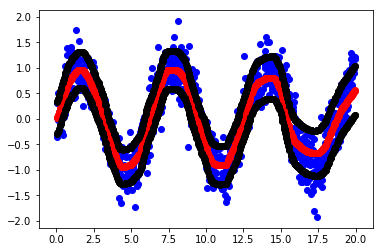

In [11]:
preds_mdn = model_mdn.predict(X_val)

preds_mdn_means = preds_mdn[:, :modes]
preds_mdn_stds = preds_mdn[:, modes:2*modes]
preds_mdn_weights = preds_mdn[:, 2*modes:3*modes]

preds_mdn_final = np.sum(preds_mdn_means*preds_mdn_weights, axis=1)
std_mdn_final = np.exp(np.sum(preds_mdn_stds*preds_mdn_weights, axis=1))

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds_mdn_final, color='r')
plt.scatter(X_val, preds_mdn_final + std_mdn_final, color='k')
plt.scatter(X_val, preds_mdn_final - std_mdn_final, color='k')
plt.show()

In [12]:
print('Mean sigma:')
print(std_mdn_final.mean())

Mean sigma:
0.39393684


# Error

Errors of mdn

In [13]:
error = np.mean(np.abs(preds_mdn_final - Y_val))

print('Error MDN: ' + str(error))

Error MDN: 0.2689752230061381


# Visualize uncertainty estimate

Variance depending on prediction error for MDN

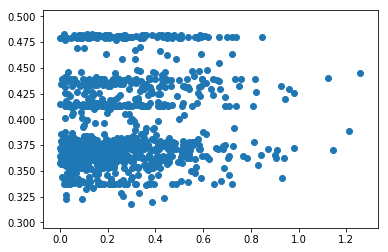

In [14]:
plt.figure()
plt.scatter(np.abs(preds_mdn_final - Y_val), std_mdn_final)
plt.show()

# Run on out of distribution samples X_test

MDN

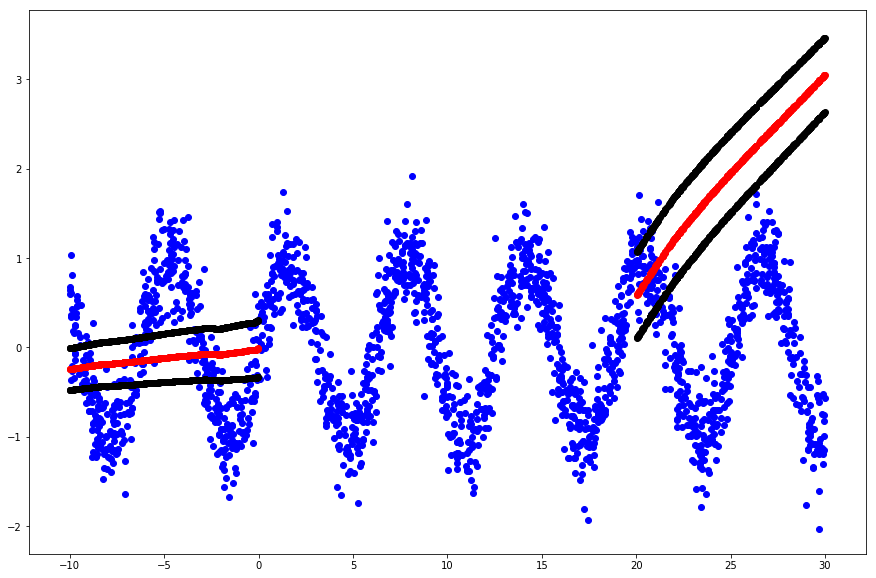

In [15]:
preds_mdn = model_mdn.predict(X_test)

preds_mdn_means = preds_mdn[:, :modes]
preds_mdn_stds = preds_mdn[:, modes:2*modes]
preds_mdn_weights = preds_mdn[:, 2*modes:3*modes]

preds_mdn_final = np.sum(preds_mdn_means*preds_mdn_weights, axis=1)
std_mdn_final = np.exp(np.sum(preds_mdn_stds*preds_mdn_weights, axis=1))

plt.figure(figsize=(15,10))
plt.scatter(X_test, Y_test, color='b')
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_test, preds_mdn_final, color='r')
plt.scatter(X_test, preds_mdn_final + std_mdn_final, color='k')
plt.scatter(X_test, preds_mdn_final - std_mdn_final, color='k')
plt.show()

In [16]:
print('Mean sigma:')
print(std_mdn_final.mean())

Mean sigma:
0.35905817
